# CNN, LSTM and Attention for IMDB Movie Review classification
* Author: Johannes Maucher
* Last Update: 23.11.2020

The IMDB Movie Review corpus is a standard dataset for the evaluation of text-classifiers. It consists of 25000 movies reviews from IMDB, labeled by sentiment (positive/negative). In this notebook a Convolutional Neural Network (CNN) is implemented for sentiment classification of IMDB reviews.

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Dense, Input, Flatten, Conv1D, MaxPooling1D, Dropout, Concatenate, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import imdb

In [4]:
MAX_SEQUENCE_LENGTH = 500  # all text-sequences are padded to this length
MAX_NB_WORDS = 10000        # number of most-frequent words that are regarded, all others are ignored
EMBEDDING_DIM = 100         # dimension of word-embedding
INDEX_FROM=3

## Access IMDB dataset
The [IMDB dataset](https://keras.io/datasets/) is already available in Keras and can easily be accessed by

`imdb.load_data()`. 

The returned dataset contains the sequence of word indices for each review. 

In [73]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MAX_NB_WORDS,index_from=INDEX_FROM)

In [74]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [75]:
X_train[0][:10] #plot first 10 elements of the sequence

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

The representation of text as sequence of integers is good for Machine Learning algorithms, but useless for human text understanding. Therefore, we also access the word-index from [Keras IMDB dataset](https://keras.io/api/datasets/imdb/), which maps words to the associated integer-IDs. Since we like to map integer-IDs to words we calculate the inverse wordindex `inv_wordindex`: 

In [76]:
wordindex=imdb.get_word_index(path="imdb_word_index.json")

In [77]:
wordindex = {k:(v+INDEX_FROM) for k,v in wordindex.items()}
wordindex["<PAD>"] = 0
wordindex["<START>"] = 1
wordindex["<UNK>"] = 2
wordindex["<UNUSED>"] = 3

inv_wordindex = {value:key for key,value in wordindex.items()}

The first film-review of the training-partition then reads as follows:

In [78]:
print(' '.join(inv_wordindex[id] for id in X_train[0] ))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

Next the distribution of review-lengths (words per review) is calculated:

In [79]:
textlenghtsTrain=[len(t) for t in X_train]

In [80]:
from matplotlib import pyplot as plt

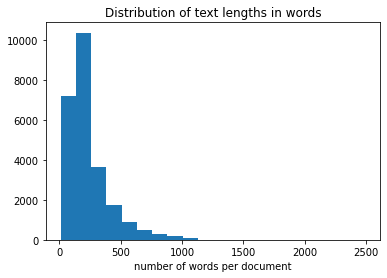

In [81]:
plt.hist(textlenghtsTrain,bins=20)
plt.title("Distribution of text lengths in words")
plt.xlabel("number of words per document")
plt.show()

## Preparing Text Sequences and Labels
All sequences must be padded to unique length of `MAX_SEQUENCE_LENGTH`. This means, that longer sequences are cut and shorter sequences are filled with zeros. For this Keras provides the `pad_sequences()`-function. 

In [82]:
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

In [83]:
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

Moreover, all class-labels must be represented in one-hot-encoded form:

In [84]:
y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))
print('Shape of Training Data Input:', X_train.shape)
print('Shape of Training Data Labels:', y_train.shape)

Shape of Training Data Input: (25000, 500)
Shape of Training Data Labels: (25000, 2)


In [85]:
print('Number of positive and negative reviews in training and validation set ')
print (y_train.sum(axis=0))
print (y_test.sum(axis=0))

Number of positive and negative reviews in training and validation set 
[12500. 12500.]
[12500. 12500.]


## CNN with 2 Convolutional Layers

The first network architecture consists of
* an embedding layer. This layer takes sequences of integers and learns word-embeddings. The sequences of word-embeddings are then passed to the first convolutional layer
* two 1D-convolutional layers with different number of filters and different filter-sizes
* two Max-Pooling layers to reduce the number of neurons, required in the following layers
* a MLP classifier with one hidden layer and the output layer

### Prepare Embedding Matrix and -Layer 

In [86]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

### Define CNN architecture

In [87]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(32, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(2)(l_cov1)
l_cov2 = Conv1D(64, 3, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(64, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)
model = Model(sequence_input, preds)

### Train Network

In [88]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 32)           16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 248, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 246, 64)           6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)             

In [89]:
print("model fitting - simplified convolutional neural network")
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=6, verbose=False, batch_size=128)

model fitting - simplified convolutional neural network


In [90]:
%matplotlib inline
from matplotlib import pyplot as plt

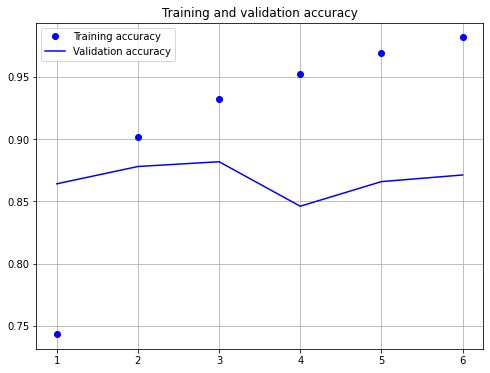

In [91]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [92]:
model.evaluate(X_test,y_test)

782/782 [==============================] - 4s 4ms/step - loss: 0.4747 - categorical_accuracy: 0.8711


[0.4746704399585724, 0.8711199760437012]

As shown above, after 6 epochs of training the cross-entropy-loss is 0.475 and the accuracy is 87.11%. However, it seems that the accuracy-value after 3 epochs has been higher, than the accuracy after 6 epochs. This indicates overfitting due to too long learning.

## CNN with different filter sizes in one layer
In [Y. Kim; Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882v2.pdf) a CNN with different filter-sizes in one layer has been proposed. This CNN is implemented below:

![KimCnn](https://maucher.home.hdm-stuttgart.de/Pics/KimCnn.png)

Source: [Y. Kim; Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882v2.pdf)

### Prepare Embedding Matrix and -Layer

In [44]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

### Define Architecture

In [45]:
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(filters=32,kernel_size=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(4)(l_conv)
    convs.append(l_pool)
    
l_merge = Concatenate(axis=1)(convs)
l_cov1= Conv1D(64, 5, activation='relu')(l_merge)
l_pool1 = GlobalMaxPool1D()(l_cov1)
#l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
#l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool1)
l_dense = Dense(64, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)

In [46]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 100)     1000000     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 498, 32)      9632        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 497, 32)      12832       embedding_2[0][0]                
_______________________________________________________________________________________

### Train Network

In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])

In [48]:
print("model fitting - more complex convolutional neural network")
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=8, batch_size=128)

model fitting - more complex convolutional neural network
Epoch 1/8
196/196 [==============================] - 48s 245ms/step - loss: 0.4927 - categorical_accuracy: 0.7368 - val_loss: 0.4006 - val_categorical_accuracy: 0.8133
Epoch 2/8
196/196 [==============================] - 51s 263ms/step - loss: 0.2560 - categorical_accuracy: 0.8971 - val_loss: 0.3341 - val_categorical_accuracy: 0.8614
Epoch 3/8
196/196 [==============================] - 49s 251ms/step - loss: 0.1860 - categorical_accuracy: 0.9280 - val_loss: 0.2924 - val_categorical_accuracy: 0.8814
Epoch 4/8
196/196 [==============================] - 48s 245ms/step - loss: 0.1286 - categorical_accuracy: 0.9536 - val_loss: 0.4191 - val_categorical_accuracy: 0.8469
Epoch 5/8
196/196 [==============================] - 47s 241ms/step - loss: 0.0829 - categorical_accuracy: 0.9731 - val_loss: 0.3308 - val_categorical_accuracy: 0.8890
Epoch 6/8
196/196 [==============================] - 47s 241ms/step - loss: 0.0506 - categorical_accur

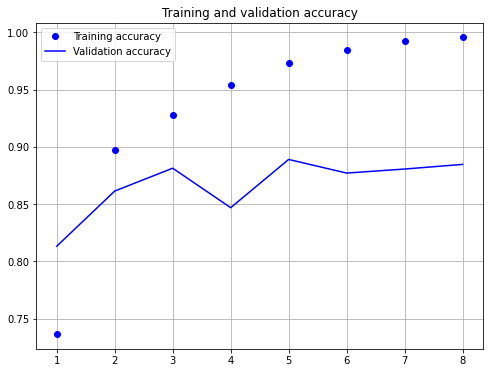

In [49]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [73]:
model.evaluate(X_test,y_test)

782/782 [==============================] - 6s 7ms/step - loss: 0.4665 - categorical_accuracy: 0.8847


[0.46650105714797974, 0.8846799731254578]

As shown above, after 8 epochs of training the cross-entropy-loss is 0.467 and the accuracy is 88.47%.

## LSTM

In [26]:
from tensorflow.keras.layers import LSTM, Bidirectional

In [27]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [28]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(64))(embedded_sequences)
preds = Dense(2, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)

In [29]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 1,084,738
Trainable params: 1,084,738
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])

print("model fitting - Bidirectional LSTM")

model fitting - Bidirectional LSTM


In [31]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=6, batch_size=128)

Epoch 1/6
196/196 [==============================] - 109s 559ms/step - loss: 0.4442 - categorical_accuracy: 0.7918 - val_loss: 0.5594 - val_categorical_accuracy: 0.7815
Epoch 2/6
196/196 [==============================] - 107s 546ms/step - loss: 0.2801 - categorical_accuracy: 0.8875 - val_loss: 0.2959 - val_categorical_accuracy: 0.8790
Epoch 3/6
196/196 [==============================] - 111s 565ms/step - loss: 0.2310 - categorical_accuracy: 0.9109 - val_loss: 0.3848 - val_categorical_accuracy: 0.8536
Epoch 4/6
196/196 [==============================] - 110s 562ms/step - loss: 0.2017 - categorical_accuracy: 0.9248 - val_loss: 0.3087 - val_categorical_accuracy: 0.8729
Epoch 5/6
196/196 [==============================] - 107s 547ms/step - loss: 0.1767 - categorical_accuracy: 0.9362 - val_loss: 0.3703 - val_categorical_accuracy: 0.8671
Epoch 6/6
196/196 [==============================] - 105s 538ms/step - loss: 0.1551 - categorical_accuracy: 0.9435 - val_loss: 0.4671 - val_categorical_acc

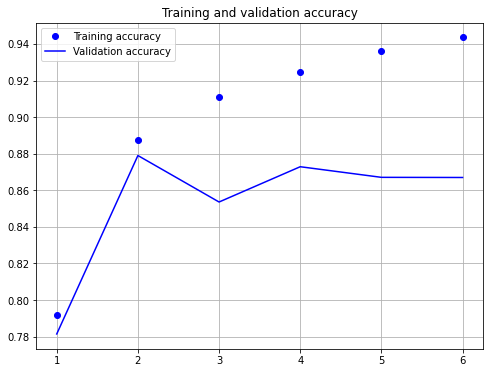

In [32]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
model.evaluate(X_test,y_test)

782/782 [==============================] - 24s 31ms/step - loss: 0.4671 - categorical_accuracy: 0.8670


[0.467098593711853, 0.8669999837875366]

As shown above, after 6 epochs of training the cross-entropy-loss is 0.467 and the accuracy is 86.7%. However, it seems that the accuracy-value after 2 epochs has been higher, than the accuracy after 6 epochs. This indicates overfitting due to too long learning.

## Bidirectional LSTM architecture with Attention

### Define Custom Attention Layer
Since Keras does not provide an attention-layer, we have to implement this type on our own. The implementation below corresponds to the attention-concept as introduced in [Bahdanau et al: Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf).

The general concept of writing custom Keras layers is described in the corresponding [Keras documentation](https://keras.io/layers/writing-your-own-keras-layers/). 

Any custom layer class inherits from the layer-class and must implement three methods:

- `build(input_shape)`: this is where you will define your weights. This method must set `self.built = True`, which can be done by calling `super([Layer], self).build()`.
- `call(x)`: this is where the layer's logic lives. Unless you want your layer to support masking, you only have to care about the first argument passed to call: the input tensor.
- `compute_output_shape(input_shape)`: in case your layer modifies the shape of its input, you should specify here the shape transformation logic. This allows Keras to do automatic shape inference.

In [63]:
from tensorflow.keras import regularizers, initializers,constraints
from tensorflow.keras.layers import Layer


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     #name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [64]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [65]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_gru = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
l_att = Attention(MAX_SEQUENCE_LENGTH)(l_gru)
preds = Dense(2, activation='softmax')(l_att)
model = Model(sequence_input, preds)

In [66]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 500, 128)          84480     
_________________________________________________________________
attention_8 (Attention)      (None, 128)               628       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 1,085,366
Trainable params: 1,085,366
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])

In [69]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=6, batch_size=128)

Epoch 1/6
196/196 [==============================] - 126s 643ms/step - loss: 0.4488 - categorical_accuracy: 0.7836 - val_loss: 0.3027 - val_categorical_accuracy: 0.8777
Epoch 2/6
196/196 [==============================] - 125s 638ms/step - loss: 0.2596 - categorical_accuracy: 0.8984 - val_loss: 0.3228 - val_categorical_accuracy: 0.8691
Epoch 3/6
196/196 [==============================] - 126s 640ms/step - loss: 0.2071 - categorical_accuracy: 0.9197 - val_loss: 0.6833 - val_categorical_accuracy: 0.7630
Epoch 4/6
196/196 [==============================] - 123s 630ms/step - loss: 0.1791 - categorical_accuracy: 0.9323 - val_loss: 0.2992 - val_categorical_accuracy: 0.8779
Epoch 5/6
196/196 [==============================] - 128s 654ms/step - loss: 0.1553 - categorical_accuracy: 0.9417 - val_loss: 0.3247 - val_categorical_accuracy: 0.8788
Epoch 6/6
196/196 [==============================] - 130s 666ms/step - loss: 0.1335 - categorical_accuracy: 0.9509 - val_loss: 0.3339 - val_categorical_acc

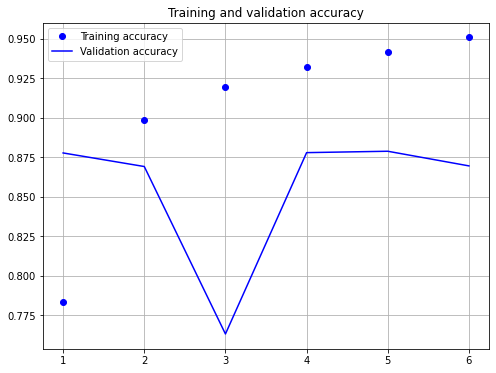

In [70]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8,6))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [71]:
model.evaluate(X_test,y_test)

782/782 [==============================] - 29s 37ms/step - loss: 0.3339 - categorical_accuracy: 0.8695


[0.33391639590263367, 0.8695200085639954]

Again, the achieved accuracy is in the same range as for the other architectures. None of the architectures has been optimized, e.g. through hyperparameter-tuning. However, the goal of this notebook is not the determination of an optimal model, but the demonstration of how modern neural network architectures can be implemented for text-classification.